# Basic Imports

In [1]:
import os
import sys
import torch
import importlib
import numpy as np
from omegaconf import OmegaConf
from taming.models import vqgan 
import numpy as np 
from PIL import Image
from einops import rearrange
from torchvision.utils import make_grid
from ldm.models.diffusion.ddim import DDIMSampler
from ldm.util import *

cwd = os.getcwd()
%reload_ext autoreload
%autoreload 2


c:\ProgramData\Anaconda3\envs\thesis\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: [WinError 127] The specified procedure could not be found
  warn(f"Failed to load image Python extension: {e}")


In [2]:
def instantiate_from_config(config):
    if not "target" in config:
        if config == '__is_first_stage__':
            return None
        elif config == "__is_unconditional__":
            return None
        raise KeyError("Expected key `target` to instantiate.")
    return get_obj_from_str(config["target"])(**config.get("params", dict()))

def load_model_from_config(config, ckpt):
    print(f"Loading model from {ckpt}")
    pl_sd = torch.load(ckpt)#, map_location="cpu")
    sd = pl_sd["state_dict"]
    model = instantiate_from_config(config.model)
    m, u = model.load_state_dict(sd, strict=False)
    model.cuda()
    model.eval()
    return model


def get_model(teacher=True):
    config = OmegaConf.load(f"{cwd}/cin256-v2-custom.yaml")  
    model = load_model_from_config(config, f"{cwd}/model.ckpt")
    return model

In [3]:
teacher = get_model()
sampler_teacher = DDIMSampler(teacher)

Loading model from d:\OneDrive\Uni\Master_Project_AI\Code\Diffusion_Thesis\cin_256/model.ckpt


c:\ProgramData\Anaconda3\envs\thesis\lib\site-packages\pytorch_lightning\utilities\distributed.py:258: LightningDeprecationWarning: `pytorch_lightning.utilities.distributed.rank_zero_only` has been deprecated in v1.8.1 and will be removed in v2.0.0. You can import it from `pytorch_lightning.utilities` instead.
  rank_zero_deprecation(


LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 400.92 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 3, 64, 64) = 12288 dimensions.
making attention of type 'vanilla' with 512 in_channels


## WITHOUT UPDATES!

In [4]:
# NUM_CLASSES = 1000
# inst_per_distil = 1
# ddim_steps = 10
# ddim_eta = 0.0
# scale = 3.0

# all_samples = list()

# with torch.no_grad():
#         for run in range(inst_per_distil):
#                 with model.ema_scope():
#                         uc = model.get_learned_conditioning(
#                                 {model.cond_stage_key: torch.tensor(1*[1000]).to(model.device)}
#                                 )
#                         for class_prompt in torch.randint(0, NUM_CLASSES, (inst_per_distil,)):
#                                 xc = torch.tensor(1*[class_prompt])
#                                 c = model.get_learned_conditioning({model.cond_stage_key: xc.to(model.device)})
                                
#                                 samples_ddim, _ = sampler.sample(S=ddim_steps,
#                                                                 conditioning=c,
#                                                                 batch_size=1,
#                                                                 shape=[3, 64, 64],
#                                                                 verbose=False,
#                                                                 unconditional_guidance_scale=scale,
#                                                                 unconditional_conditioning=uc, 
#                                                                 eta=ddim_eta,
#                                                                 keep_intermediates=True,
#                                                                 test=True,
#                                                                 intermediate_step=None,
#                                                                 total_steps=None)
                                
# # display as grid
# x_samples_ddim = model.decode_first_stage(_["x_inter"][-1])
# x_samples_ddim = torch.clamp((x_samples_ddim+1.0)/2.0, 
#                             min=0.0, max=1.0)


# grid = rearrange(x_samples_ddim, 'b c h w -> (b) c h w')
# grid = make_grid(grid, nrow=1)

# # to image
# grid = 255. * rearrange(grid, 'c h w -> h w c').cpu().numpy()
# Image.fromarray(grid.astype(np.uint8))

# WITH UPDATES!

In [5]:
# NUM_CLASSES = 1000
# inst_per_distil = 1
# ddim_steps = 10
# ddim_eta = 0.0
# scale = 3.0

# updates = int(ddim_steps / 2)

# all_samples = list()

# with torch.no_grad():
#         for run in range(inst_per_distil):
#                 with model.ema_scope():
#                         uc = model.get_learned_conditioning(
#                                 {model.cond_stage_key: torch.tensor(1*[1000]).to(model.device)}
#                                 )
#                         for class_prompt in torch.randint(0, NUM_CLASSES, (inst_per_distil,)):
#                                 sampler.make_schedule(ddim_num_steps=ddim_steps, ddim_eta=ddim_eta, verbose=False)
#                                 xc = torch.tensor([class_prompt])
#                                 c = model.get_learned_conditioning({model.cond_stage_key: xc.to(model.device)})
#                                 x_T = None
#                                 for steps in range(updates):
#                                         samples_ddim, _ = sampler.sample(S=2,
#                                                                         conditioning=c,
#                                                                         batch_size=1,
#                                                                         shape=[3, 64, 64],
#                                                                         verbose=False,
#                                                                         x_T=x_T,
#                                                                         unconditional_guidance_scale=scale,
#                                                                         unconditional_conditioning=uc, 
#                                                                         eta=ddim_eta,
#                                                                         keep_intermediates=True,
#                                                                         intermediate_step = steps*2,
#                                                                         steps_per_sampling = 2,
#                                                                         total_steps = ddim_steps)
#                                         x_T = _["x_inter"][-1]


# x_samples_ddim = model.decode_first_stage(_["x_inter"][-1])
# x_samples_ddim = torch.clamp((x_samples_ddim+1.0)/2.0, min=0.0, max=1.0)
# grid = rearrange(x_samples_ddim, 'b c h w -> (b) c h w')
# grid = make_grid(grid, nrow=1)
# grid = 255. * rearrange(grid, 'c h w -> h w c').cpu().numpy()
# Image.fromarray(grid.astype(np.uint8)) 

# With Updates and student Loss!

In [10]:
import copy
teacher = get_model()
sampler_teacher = DDIMSampler(teacher)
student = copy.deepcopy(teacher)
sampler_student = DDIMSampler(student)

Loading model from d:\OneDrive\Uni\Master_Project_AI\Code\Diffusion_Thesis\cin_256/model.ckpt
LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 400.92 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 3, 64, 64) = 12288 dimensions.
making attention of type 'vanilla' with 512 in_channels


DDIM Sampler:  10%|█         | 1/10 [00:00<00:00, 12.79it/s]


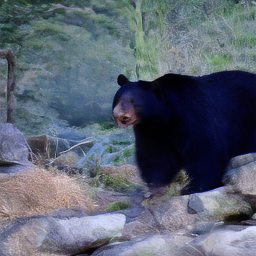

In [46]:
NUM_CLASSES = 1000
inst_per_distil = 1
ddim_steps_teacher = 20
ddim_steps_student = int(ddim_steps_teacher / 2)
TEACHER_STEPS = 2
STUDENT_STEPS = 1
ddim_eta = 0.0
scale = 3.0

updates = int(ddim_steps_teacher / TEACHER_STEPS)

all_samples = list()

with torch.no_grad():
        for run in range(inst_per_distil):
                with teacher.ema_scope():
                        uc = teacher.get_learned_conditioning(
                                {teacher.cond_stage_key: torch.tensor(1*[1000]).to(teacher.device)}
                                )
                        for class_prompt in torch.randint(0, NUM_CLASSES, (inst_per_distil,)):
                        # for class_prompt in [1]:
                                sampler_teacher.make_schedule(ddim_num_steps=ddim_steps_teacher, ddim_eta=ddim_eta, verbose=False)
                                xc = torch.tensor([class_prompt])
                                c = teacher.get_learned_conditioning({teacher.cond_stage_key: xc.to(teacher.device)})
                                x_T = None

                                sampler_student.make_schedule(ddim_num_steps=ddim_steps_student, ddim_eta=ddim_eta, verbose=False)
                                c_student = student.get_learned_conditioning({student.cond_stage_key: xc.to(student.device)})
                                for steps in range(updates):
                                        samples_ddim, teacher_intermediate, x_T_copy = sampler_teacher.sample(S=TEACHER_STEPS,
                                                                        conditioning=c,
                                                                        batch_size=1,
                                                                        shape=[3, 64, 64],
                                                                        verbose=False,
                                                                        x_T=x_T,
                                                                        unconditional_guidance_scale=scale,
                                                                        unconditional_conditioning=uc, 
                                                                        eta=ddim_eta,
                                                                        keep_intermediates=True,
                                                                        intermediate_step = steps*TEACHER_STEPS,
                                                                        steps_per_sampling = TEACHER_STEPS,
                                                                        total_steps = ddim_steps_teacher)
                                        x_T = teacher_intermediate["x_inter"][-1]

                                        with torch.enable_grad():
                                                if steps == 0:
                                                        x_T_student = x_T_copy
                                                
                                                samples_ddim, student_intermediate, x_T_copy = sampler_student.sample(S=STUDENT_STEPS,
                                                                                conditioning=c_student,
                                                                                batch_size=1,
                                                                                shape=[3, 64, 64],
                                                                                verbose=False,
                                                                                x_T=x_T_student,
                                                                                unconditional_guidance_scale=scale,
                                                                                unconditional_conditioning=uc, 
                                                                                eta=ddim_eta,
                                                                                keep_intermediates=True,
                                                                                intermediate_step = steps*STUDENT_STEPS,
                                                                                steps_per_sampling = STUDENT_STEPS,
                                                                                total_steps = ddim_steps_student)
                                                x_T_student = student_intermediate["x_inter"][-1]



x_samples_ddim = teacher.decode_first_stage(teacher_intermediate["x_inter"][-1])
x_samples_ddim = torch.clamp((x_samples_ddim+1.0)/2.0, min=0.0, max=1.0)
grid = rearrange(x_samples_ddim, 'b c h w -> (b) c h w')
grid = make_grid(grid, nrow=1)
grid = 255. * rearrange(grid, 'c h w -> h w c').cpu().numpy()
Image.fromarray(grid.astype(np.uint8)) 

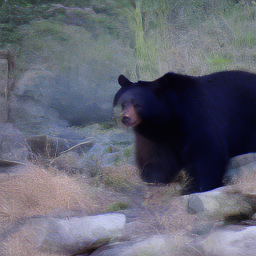

In [47]:
x_samples_ddim = teacher.decode_first_stage(student_intermediate["x_inter"][-1])
x_samples_ddim = torch.clamp((x_samples_ddim+1.0)/2.0, min=0.0, max=1.0)
grid = rearrange(x_samples_ddim, 'b c h w -> (b) c h w')
grid = make_grid(grid, nrow=1)
grid = 255. * rearrange(grid, 'c h w -> h w c').cpu().numpy()
Image.fromarray(grid.astype(np.uint8)) 